# SPAIN TIME SERIES FORECASTING

### 0. LIBRARIES

In [1]:
%%capture
%pip install plotly statsmodels scikit-learn xgboost pmdarima statsforecast arch

In [98]:
# Core Libraries
import numpy as np
import pandas as pd
import itertools


# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patheffects as pe
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time Series Analysis & Statistical Models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
from scipy.signal import periodogram
from scipy.fft import fft
from scipy import stats

# ARCH/GARCH Models
import arch
from arch import arch_model
from statsforecast import StatsForecast
from statsforecast.models import ARCH, GARCH, Naive

# Machine Learning & Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from xgboost import XGBRegressor
import xgboost as xgb

# Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Jupyter Notebook Settings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


### 1. IMPORT DATASET

In [150]:
df = pd.read_excel("NEW_SPAIN_EPU_INDEX.xlsx",skiprows=1)

In [151]:
df.head() 

,Year,Month,Index value
0,1997,1,31.018169
1,1997,2,50.695080
2,1997,3,43.754341
3,1997,4,43.427864
4,1997,5,120.413849


In [152]:
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df = df.set_index('Date').sort_index()
df = df.reset_index()
df = df.drop(columns="Year")
df.tail()

,Date,Month,Index value
335,2024-12-01,12,180.977631
336,2025-01-01,1,191.908890
337,2025-02-01,2,147.651108
338,2025-03-01,3,174.871140
339,2025-04-01,4,212.141449


### 2. EXPLORY DATA ANALYSIS

In [103]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         340 non-null    datetime64[ns]
 1   Month        340 non-null    int64         
 2   Index value  340 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.1 KB


,Date,Month,Index value
count,340,340.000000,340.000000
mean,2011-02-15 02:07:03.529411840,6.452941,112.745058
min,1997-01-01 00:00:00,1.000000,31.018169
25%,2004-01-24 06:00:00,3.000000,80.984438
50%,2011-02-15 00:00:00,6.000000,108.462086
75%,2018-03-08 18:00:00,9.000000,140.231647
max,2025-04-01 00:00:00,12.000000,261.609741
std,NaN,3.465909,40.348093


In [107]:
eda_df = df.copy() #edadataset, to avoid unwant inplace in default data
eda_df.head()

,Date,Month,Index value
0,1997-01-01,1,31.018169
1,1997-02-01,2,50.695080
2,1997-03-01,3,43.754341
3,1997-04-01,4,43.427864
4,1997-05-01,5,120.413849


In [ ]:
fig = go.Figure()
# testing
fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['Index value'],
    mode='lines',
    name='EPU Index',
    line=dict(color="#2f4b7c", width=2),
))

fig.update_layout(
    title=dict(
        text='<b>SPAIN EPU INDEX VISUALIZATION</b>',
        x=0.5,
        font=dict(size=26)
    ),
    xaxis_title='Date',
    yaxis_title='EPU Index Value',
    width=1000,
    height=500,
    template='seaborn',
    font=dict(size=15),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1,
        font=dict(size=15)
    )
)

fig.update_xaxes(
    showgrid=True,
    gridwidth=1.2,
    dtick="M24",
    tickformat="%Y",
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=True,
    ticklabelstandoff=10  # khoảng cách tick với trục
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1.2,
    zeroline=True,
    zerolinewidth=1.5,
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=True,
    ticklabelstandoff=10
)


fig.show()


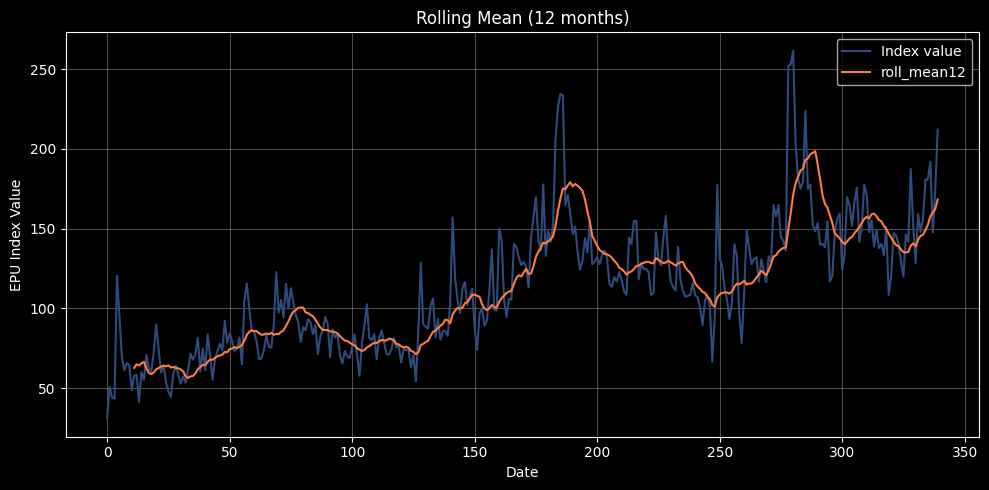

In [11]:
colors = ['#2f4b7c', '#ff7c43']
eda_df["roll_mean12"] = eda_df["Index value"].rolling(12).mean()
eda_df[['Index value', 'roll_mean12']].plot(
    figsize=(10, 5),
    linewidth=1.5,
    color=colors,
    title="Rolling Mean (12 months)"
)

plt.grid(alpha=0.3)
plt.xlabel("Date")
plt.ylabel("EPU Index Value")
plt.tight_layout()
plt.show()

Also this is trend lines to for more approachable with plotly visualization

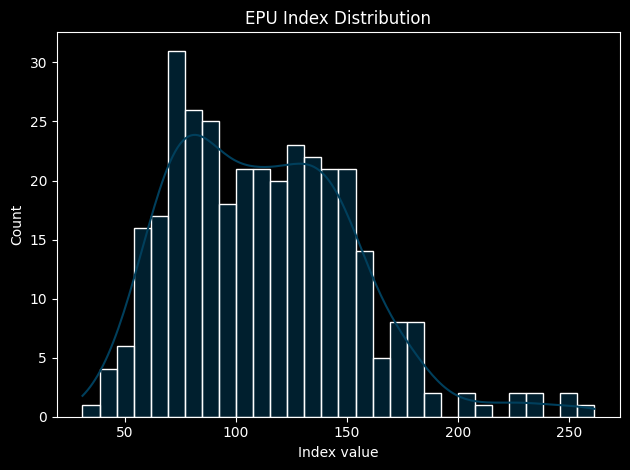

In [12]:
sns.histplot(
    eda_df['Index value'],
    bins=30,
    kde=True,
    color='#003f5c'
)

plt.title("EPU Index Distribution")
plt.tight_layout()
plt.show()


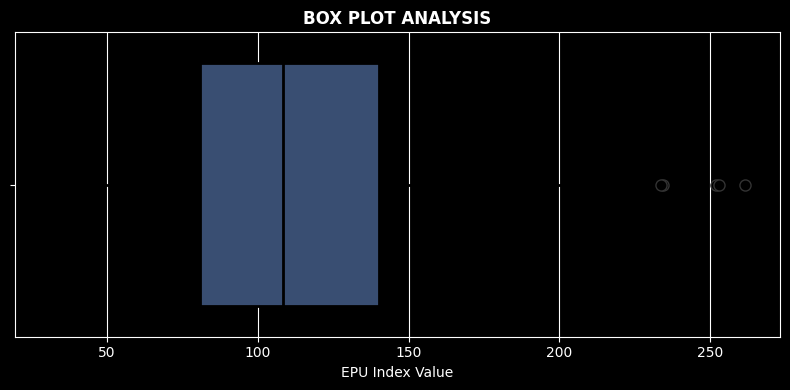

5th percentile: 58.21
10th percentile: 65.65
25th percentile: 80.98
50th percentile: 108.46
75th percentile: 140.23
90th percentile: 159.63
95th percentile: 177.71


In [147]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    x=eda_df['Index value'],
    orient='h',
    color='#2f4b7c',
    boxprops=dict(edgecolor="black", linewidth=2),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    flierprops=dict(markerfacecolor='black', marker='o', markersize=8, linestyle='none')
)

plt.title("BOX PLOT ANALYSIS", fontweight='bold')
plt.xlabel("EPU Index Value")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

percentiles = [5, 10, 25, 50, 75, 90, 95]
for p in percentiles:
    value = np.percentile(df['Index value'], p) 
    print(f"{p}th percentile: {value:.2f}")


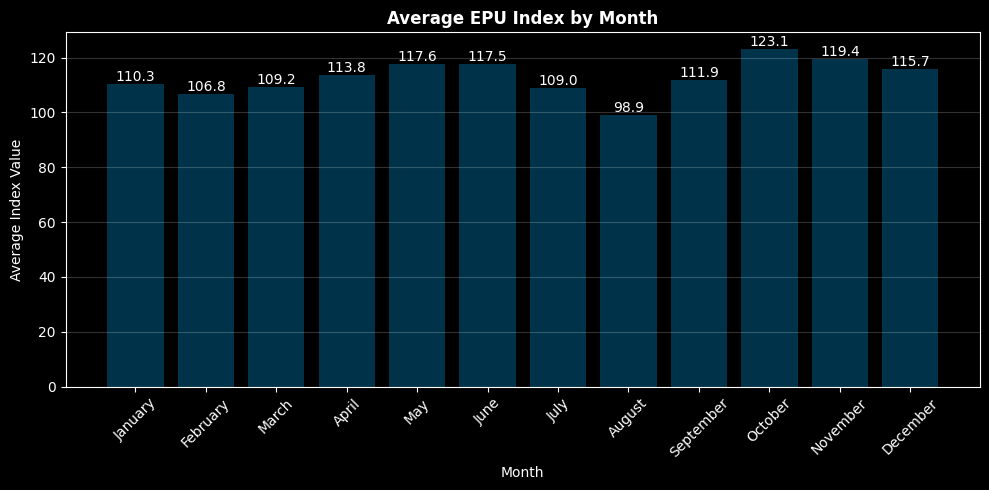

In [18]:
eda_df['Month'] = eda_df['Date'].dt.month
eda_df['Month_Name'] = eda_df['Date'].dt.month_name()

monthly_stats = eda_df.groupby('Month').agg(mean=('Index value', 'mean'), std=('Index value', 'std')).reset_index()
monthly_stats['Month_Name'] = pd.to_datetime(monthly_stats['Month'], format='%m').dt.month_name()

plt.figure(figsize=(10, 5))
bars = plt.bar(monthly_stats['Month_Name'], monthly_stats['mean'], color='#003f5c', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('Average EPU Index by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Index Value')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


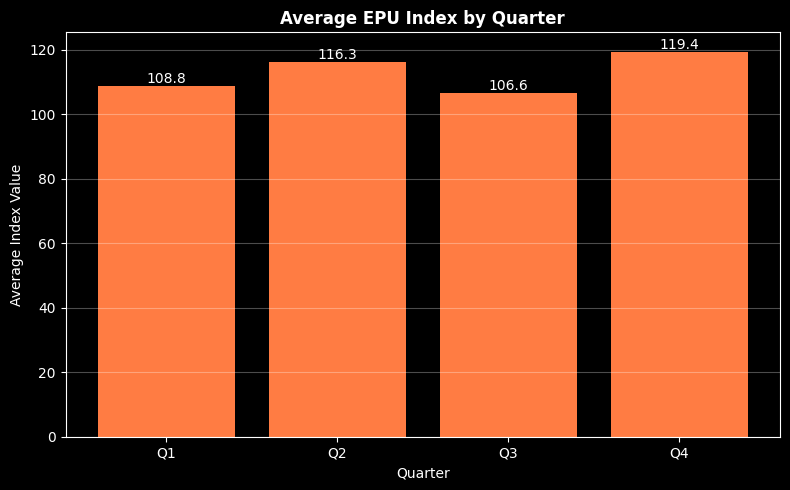

In [108]:
eda_df['Quarter'] = eda_df['Date'].dt.quarter
quarterly_stats = eda_df.groupby('Quarter')['Index value'].mean().reset_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(quarterly_stats['Quarter'], quarterly_stats['Index value'], color='#ff7c43')

# Annotate
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('Average EPU Index by Quarter', fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Average Index Value')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

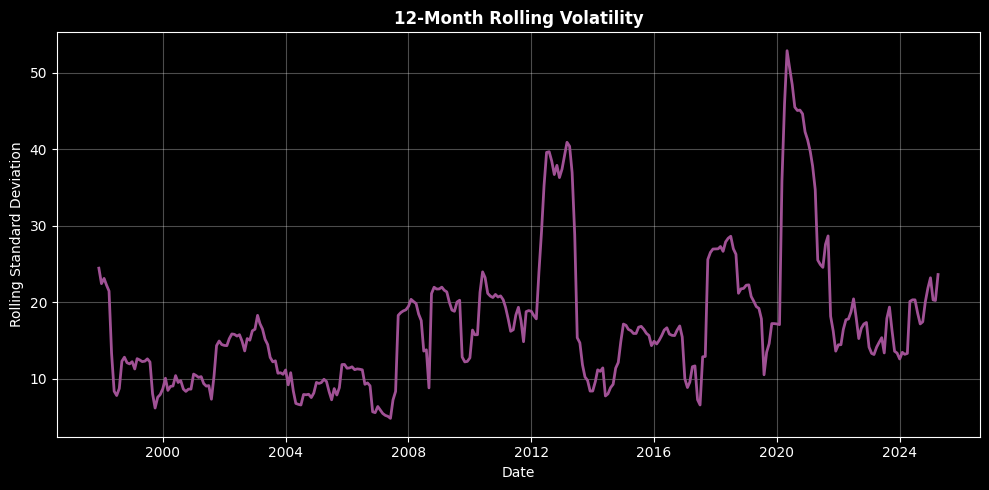

In [20]:
rolling_vol = eda_df.set_index('Date')['Index value'].rolling(window=12).std()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(rolling_vol.index, rolling_vol.values, color="#a05195", linewidth=2)

ax.set_title('12-Month Rolling Volatility', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Standard Deviation')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


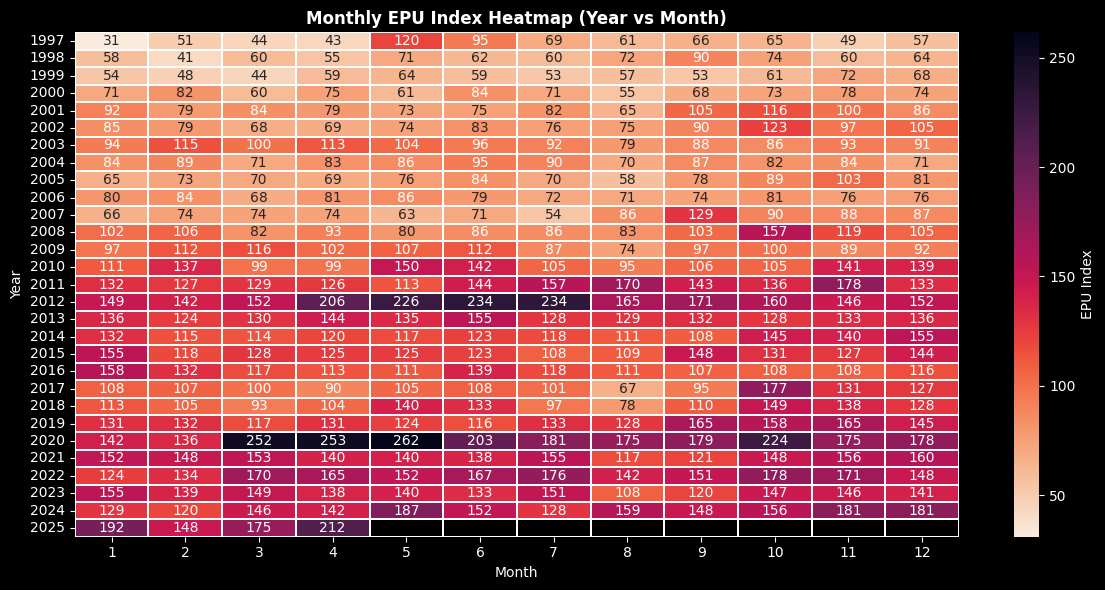

In [23]:
pivot = df.pivot_table(
    index=df['Date'].dt.year,
    columns=df['Date'].dt.month,
    values='Index value',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="rocket_r", annot=True, fmt=".0f", linewidths=0.3, cbar_kws={'label': 'EPU Index'})
plt.title("Monthly EPU Index Heatmap (Year vs Month)", fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


### 3. DATA PREPROCESSING

In [86]:
df_sorted = df.sort_values('Date')
date_diff = df_sorted['Date'].diff().dt.days.dropna()

In [ ]:
df['Month'] = df['Month'].astype(int)
df['Index value'] = df['Index value'].astype(float)

In [25]:
df.dropna(inplace=True)

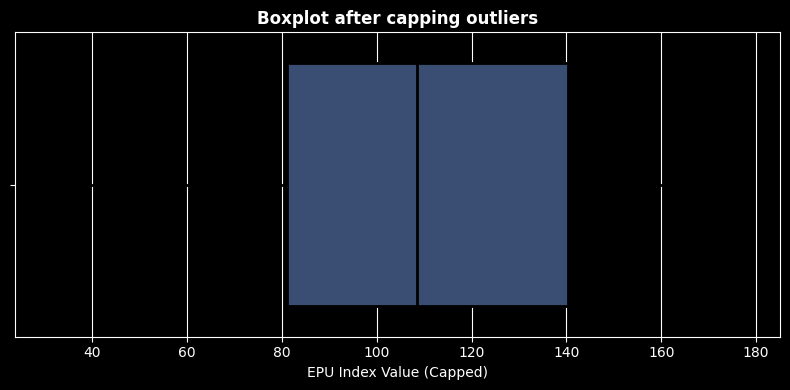

In [160]:
upper = eda_df['Index value'].quantile(0.95) 
df['Index_capped'] = np.where(df['Index value'] > upper, upper, df['Index value'])
plt.figure(figsize=(8, 4))
sns.boxplot(
    x=eda_df['Index_capped'],
    orient='h',
    color='#2f4b7c',
    boxprops=dict(edgecolor="black", linewidth=2),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    flierprops=dict(markerfacecolor='black', marker='o', markersize=8, linestyle='none')
)

plt.title("Boxplot after capping outliers", fontweight='bold') 
plt.xlabel("EPU Index Value (Capped)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()




In [168]:
q1 = df['Index value'].quantile(0.25)
q3 = df['Index value'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

df['is_outlier'] = df['Index value'] > upper
df['Index_winsor'] = np.where(df['Index value'] > upper, upper, df['Index value'])

df_avg = df.copy() #For average model
df_avg['Index value'] = df_avg['Index_winsor']
df_avg.drop(columns=['Index value'], inplace=True)

df_vol = df.copy() #For volatily model


In [169]:
df_avg

,Date,Month,Index_capped,is_outlier,Index_winsor
0,1997-01-01,1,31.018169,False,31.018169
1,1997-02-01,2,50.695080,False,50.695080
2,1997-03-01,3,43.754341,False,43.754341
3,1997-04-01,4,43.427864,False,43.427864
4,1997-05-01,5,120.413849,False,120.413849
...,...,...,...,...,...
335,2024-12-01,12,177.708503,False,180.977631
336,2025-01-01,1,177.708503,False,191.908890
337,2025-02-01,2,147.651108,False,147.651108
338,2025-03-01,3,174.871140,False,174.871140


With the model average, i use winsorize/cap at IQR point to avoid the critical effect, On the one hand, i remain the dataset df to visualize exactly the large volatility

In [114]:
def check_stationarity(series, p_significant=0.05):
    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [171]:
check_stationarity(df_avg["Index_winsor"])

ADF Statistic : -1.43758, p-value: 0.56413
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
KPSS Statistic: 2.20793, p-value: 0.01000
Non-stationary


In [174]:
diff = df_avg['Index_winsor'].diff(1).dropna()

In [175]:
check_stationarity(diff)

ADF Statistic : -8.01110, p-value: 0.00000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
KPSS Statistic: 0.12299, p-value: 0.10000
Stationary


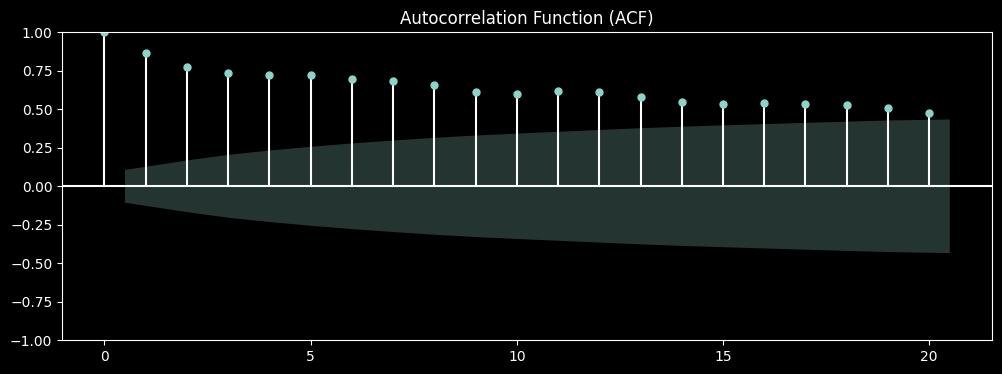

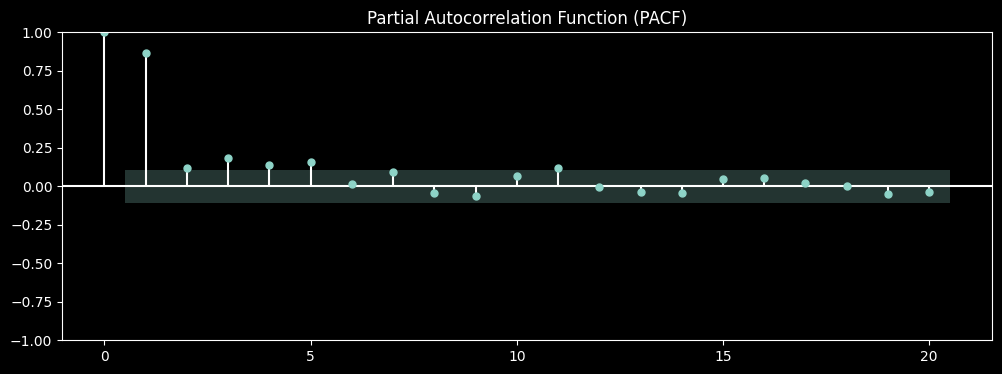

In [176]:
# Plot the ACF
fig_acf = plot_acf(df['Index value'], lags=20, title='Autocorrelation Function (ACF)')
fig_acf.set_size_inches(12,4)
plt.show();

# Plot the PACF
fig_pacf = plot_pacf(df['Index value'], lags=20, title='Partial Autocorrelation Function (PACF)')
fig_pacf.set_size_inches(12,4)
plt.show();

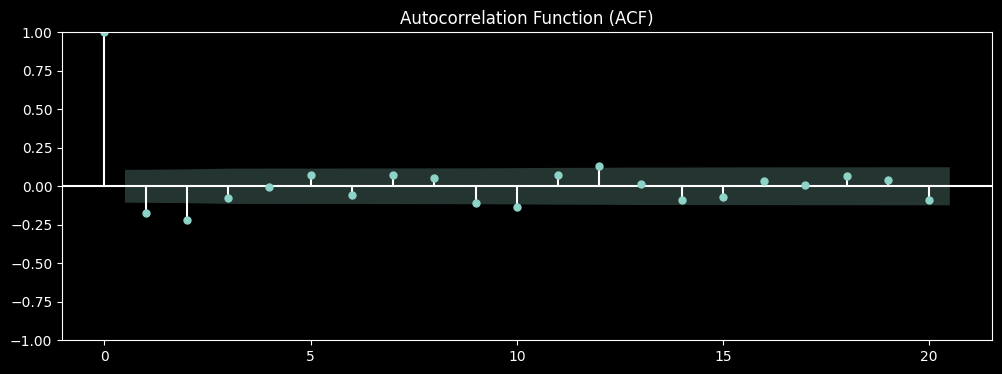

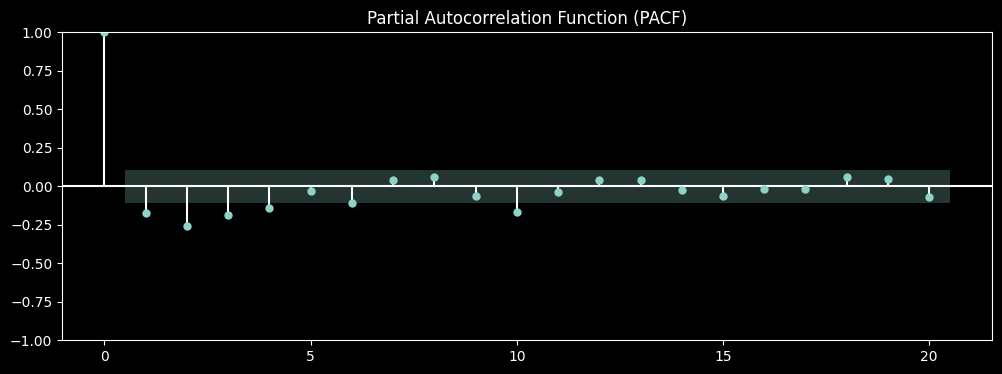

In [177]:
# Plot the ACF
fig_acf = plot_acf(diff, lags=20, title='Autocorrelation Function (ACF)')
fig_acf.set_size_inches(12,4)
plt.show();

# Plot the PACF
fig_pacf = plot_pacf(diff, lags=20, title='Partial Autocorrelation Function (PACF)')
fig_pacf.set_size_inches(12,4)
plt.show();

The quality of Decomposition is great!, appropriated for seasonal model like SARIMA


After differencing the data, the data is stationary. have no autocorrelation.

From the ACF above plot, there are no significant coefficients after lag 0. This is a clear indicator that we are dealing with a random walk as the first difference of the series is stationary & it is also not correlated

In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft

# --------------------------------------
# CONFIG
# --------------------------------------
TARGET_COL = 'Index_value'
DATE_COL = 'Date'
LAGS = [1, 2, 6, 12]
WINDOWS = [3, 6, 12]
SHOCK_EVENTS = {
    'crisis_2012': ('2012-06-01', '2012-07-31'),
    'covid_2020':  ('2020-03-01', '2020-05-31'),
}

# --------------------------------------
# FUNCTIONS
# --------------------------------------
def add_date_features(df):
    df = df.copy()
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df['month']   = df[DATE_COL].dt.month
    df['quarter'] = df[DATE_COL].dt.quarter
    df['year']    = df[DATE_COL].dt.year
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

def add_lag_features(df, lags):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[TARGET_COL].shift(lag)
    return df

def add_rolling_features(df, windows):
    df = df.copy()
    shifted = df[TARGET_COL].shift(1)
    for w in windows:
        df[f'roll_mean_{w}'] = shifted.rolling(window=w, min_periods=w).mean()
        df[f'roll_std_{w}']  = shifted.rolling(window=w, min_periods=w).std()
    return df

def add_fourier_features(df):
    df = df.copy()
    vals = df[TARGET_COL].fillna(0).values
    ft = fft(vals)
    df['fft_real'] = np.real(ft)
    df['fft_imag'] = np.imag(ft)
    return df

def add_shock_dummies(df, shock_events):
    df = df.copy()
    for name, (start, end) in shock_events.items():
        mask = (df[DATE_COL] >= pd.to_datetime(start)) & (df[DATE_COL] <= pd.to_datetime(end))
        df[name] = mask.astype(int)
    return df

# --------------------------------------
# PIPELINE RUNNER
# --------------------------------------
def run_feature_engineering_pipeline(df):
    df_out = df.copy()
    df_out = add_date_features(df_out)
    df_out = add_lag_features(df_out, LAGS)
    df_out = add_rolling_features(df_out, WINDOWS)
    df_out = add_fourier_features(df_out)
    df_out = add_shock_dummies(df_out, SHOCK_EVENTS)
    return df_out

# --------------------------------------
# USAGE
# --------------------------------------
# Assume you already have your raw dataframe:
# raw_df = pd.read_csv('your_data.csv')
# fe_df = run_feature_engineering_pipeline(raw_df)


In [2]:
fe_df = run_feature_engineering_pipeline(df)


NameError: name 'df' is not defined

### 5. MODELLING

In [113]:
n_total = len(fe_df)
n_test = 12
n_valid = int(0.18 * n_total)      

# Index slice
train_end = n_total - n_valid - n_test
valid_end = n_total - n_test

X = fe_df.drop(columns=['Date', 'Index value'])
y = fe_df['Index value']

X_train = X.iloc[:train_end].copy()
y_train = y.iloc[:train_end].copy()

X_valid = X.iloc[train_end:valid_end].copy()
y_valid = y.iloc[train_end:valid_end].copy()

X_test = X.iloc[valid_end:].copy()
y_test = y.iloc[valid_end:].copy()

print(len(X_train), len(X_valid), len(X_test))


257 59 12


#### 5.1. MOVING AVERAGE

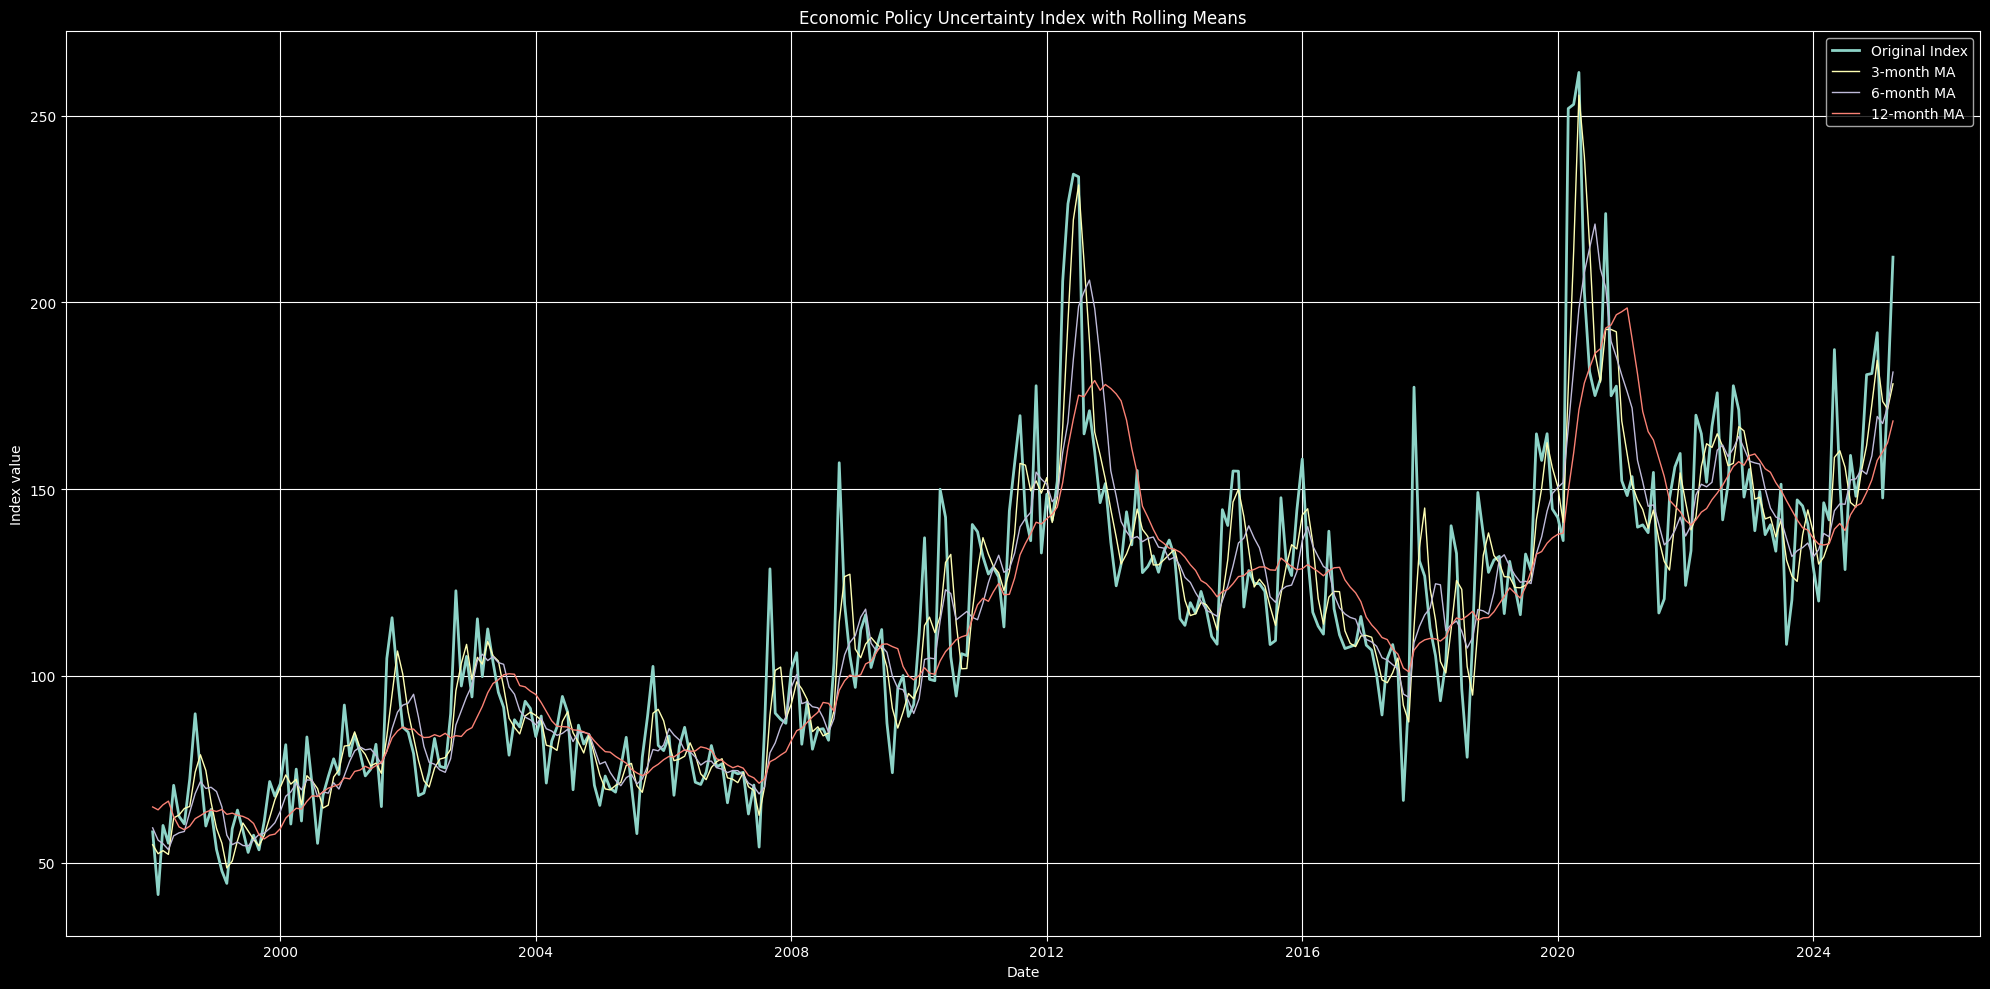

In [47]:
# Visualization of original Index and rolling means
plt.figure(figsize=(20, 10))
plt.plot(fe_df['Date'], fe_df['Index value'], label='Original Index', linewidth=2)
plt.plot(fe_df['Date'], fe_df['roll_mean_3'], label='3-month MA', linewidth=1)
plt.plot(fe_df['Date'], fe_df['roll_mean_6'], label='6-month MA', linewidth=1)
plt.plot(fe_df['Date'], fe_df['roll_mean_12'], label='12-month MA', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Index value')
plt.title('Economic Policy Uncertainty Index with Rolling Means')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
n_test = 12

train, test = fe_df['Index value'][:-n_test], fe_df['Index value'][-n_test:]
dates_test   = fe_df['Date'][-n_test:]

In [49]:

results = []
y_true = test.values
for w in [3, 6, 12]:
    # forecast
    preds = [fe_df['Index value'].iloc[max(0,i-w):i].mean()
             for i in range(len(train), len(train)+len(test))]
    y_pred = np.array(preds)

    # metrics
    rmse = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    results.append({'window': w, 'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape})

metrics_df = pd.DataFrame(results).set_index('window')
print(metrics_df)


              RMSE        MAE   MAPE (%)
window                                  
3       689.676216  20.788323  12.243745
6       640.494979  20.902687  11.904563
12      842.421013  24.419754  13.702740


#### 5.2. ARIMA

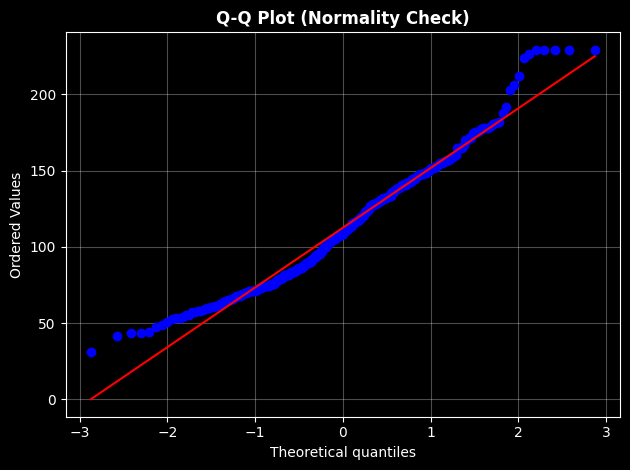

In [179]:
stats.probplot(df_avg['Index_winsor'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [180]:
auto_arima_model = pm.auto_arima(
    df_avg["Index_winsor"],
    start_p=0, max_p=5,         
    d=1,                        
    start_q=0, max_q=5,        
    seasonal=False,             # disable seasonal
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# 2. Kết quả
print(auto_arima_model.summary())

# 3. Lấy tham số tốt nhất
best_order_arima = auto_arima_model.order
print("Best ARIMA order:", best_order_arima)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2975.202, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2966.679, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2951.952, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2973.460, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2923.877, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2924.895, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2924.830, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2926.828, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2923.090, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2950.580, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2924.255, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2924.176, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2926.424, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0]             : 

In [181]:
model_arima = ARIMA(df["Index value"], order=(0, 1, 2))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Index value   No. Observations:                  340
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1471.910
Date:                Thu, 26 Jun 2025   AIC                           2949.819
Time:                        20:44:21   BIC                           2961.297
Sample:                             0   HQIC                          2954.393
                                - 340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3222      0.044     -7.324      0.000      -0.408      -0.236
ma.L2         -0.2933      0.042     -7.006      0.000      -0.375      -0.211
sigma2       345.4210     13.952     24.758      0.0

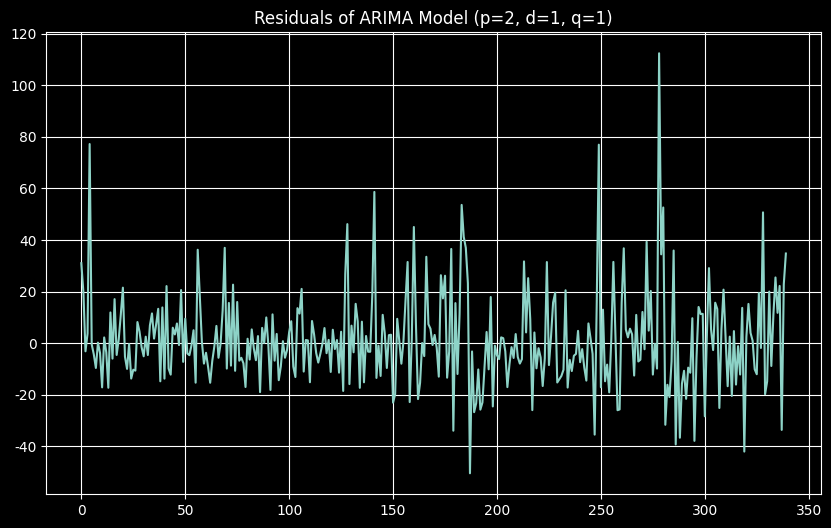

In [182]:
# Residual analysis
residuals = model_arima_fit.resid
plt.figure(figsize=(10, 6))

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.plot(residuals)
plt.title('Residuals of ARIMA Model (p=2, d=1, q=1)')
plt.grid()
plt.show()

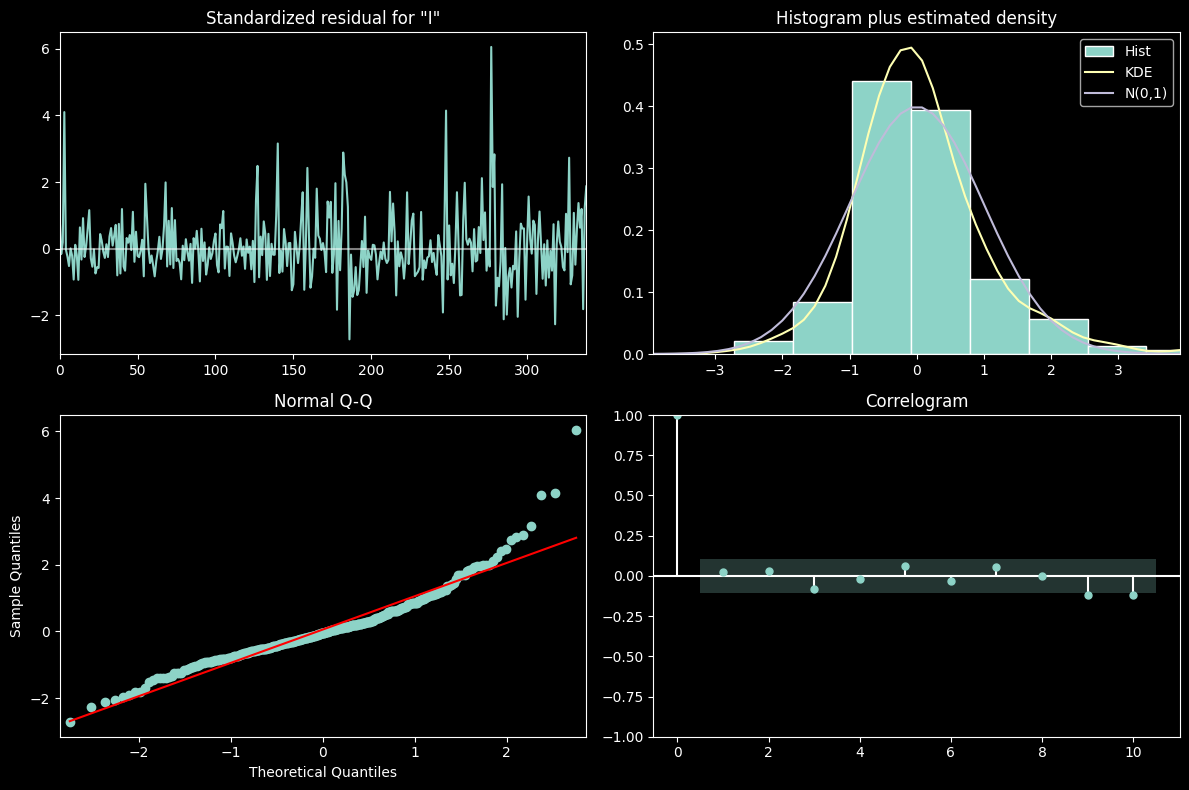

In [183]:
fc = model_arima_fit.get_forecast(steps=12)
y_pred = fc.predicted_mean
conf_int = fc.conf_int()
model_arima_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

train: 328  test: 12  pred: 12
ARIMA MAE  = 32.606
ARIMA RMSE = 1483.374


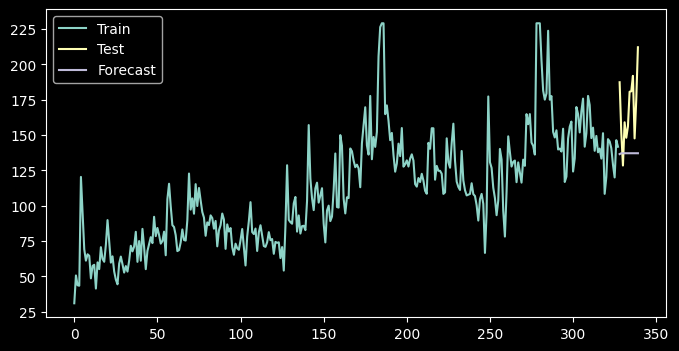

In [185]:
order = (0, 1, 2)  
y = df_avg['Index_winsor']
train, test = y.iloc[:-12], y.iloc[-12:]
h = len(test)  #12
model = ARIMA(train, order=order).fit()


y_pred = model.forecast(steps=h)  
y_pred = pd.Series(y_pred.values, index=test.index)

print("train:", len(train), " test:", len(test), " pred:", len(y_pred))

mae  = mean_absolute_error(test, y_pred)
rmse = mean_squared_error(test, y_pred)
print(f"ARIMA MAE  = {mae:.3f}")
print(f"ARIMA RMSE = {rmse:.3f}")

plt.figure(figsize=(8,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test,   label='Test')
plt.plot(y_pred.index, y_pred, label='Forecast')
plt.legend()
plt.show()

#### 5.3. SARIMAX

In [186]:
auto_sarima_model = pm.auto_arima(
    df_avg["Index_winsor"],
    start_p=0, max_p=5,         
    d=1,                       
    start_q=0, max_q=5,        
    seasonal=True,             
    m=12,                      
    D=1,                      
    start_P=0, max_P=2,        
    start_Q=0, max_Q=2,         
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


print(auto_sarima_model.summary())


best_order_sarima        = auto_sarima_model.order
best_seasonal_order_sarima = auto_sarima_model.seasonal_order
print("Best SARIMA order:", best_order_sarima)
print("Best SARIMA seasonal_order:", best_seasonal_order_sarima)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3031.811, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2936.365, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3013.162, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2909.132, Time=0.41 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2921.804, Time=0.31 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2893.405, Time=0.47 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2924.233, Time=0.20 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2890.624, Time=0.73 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2921.339, Time=0.37 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=i

In [187]:
model_sarimax = SARIMAX(
    endog=df["Index value"],
    order=(0, 1, 2),
    seasonal_order=(2, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_sarimax_fit = model_sarimax.fit(disp=False)
print(model_sarimax_fit.summary())

# Forecast
h = 12
fc = model_sarimax_fit.get_forecast(steps=h)


                                      SARIMAX Results                                      
Dep. Variable:                         Index value   No. Observations:                  340
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood               -1345.544
Date:                             Thu, 26 Jun 2025   AIC                           2701.087
Time:                                     20:48:05   BIC                           2719.656
Sample:                                          0   HQIC                          2708.516
                                             - 340                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2911      0.051     -5.669      0.000      -0.392      -0.190
ma.L2         -0.2212      

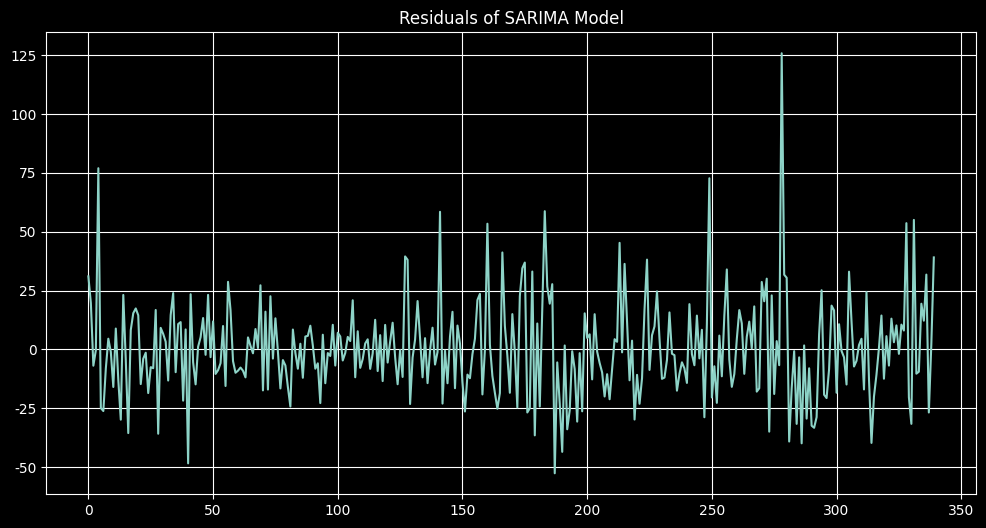

In [188]:
residuals = model_sarimax_fit.resid
plt.figure(figsize=(12, 6))

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.grid()
plt.show()

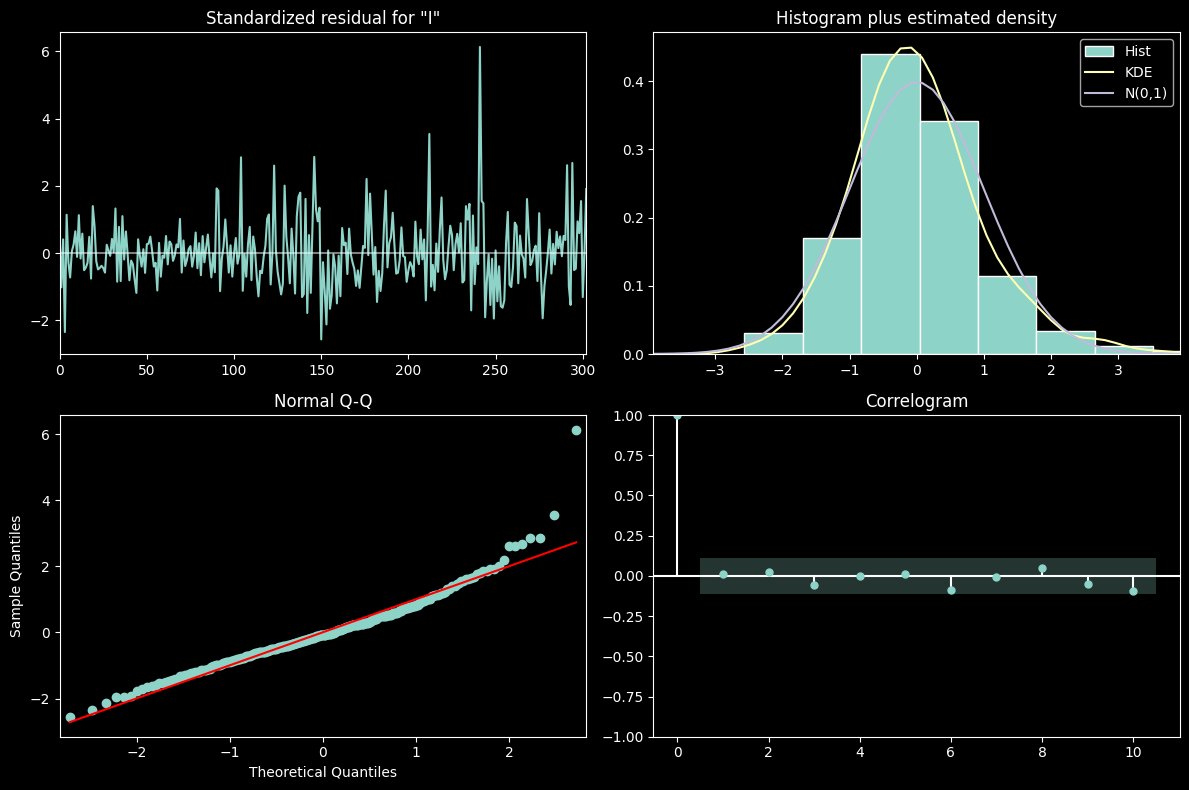

In [189]:
model_sarimax_fit = model_sarimax.fit(disp=False)
model_sarimax_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [190]:
order          = (2, 1, 1)         
seasonal_order = (2, 1, 0, 12)     
n_test         = 12      

In [195]:
y = df_avg['Index_winsor']
test_size = 12
train = y[:-test_size]
test = y[-test_size:]


SARIMA MAE  = 27.142
SARIMA RMSE = 1032.685


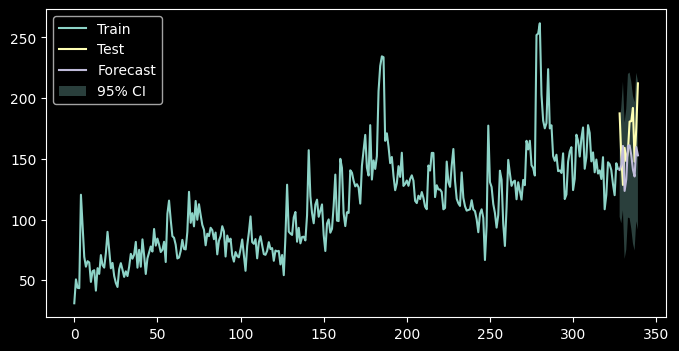

In [194]:
model = SARIMAX(
    endog          = train,
    order          = order,
    seasonal_order = seasonal_order,
    enforce_stationarity   = False,
    enforce_invertibility   = False
)
res = model.fit(disp=False)

# 3) Forecast h bước
fc      = res.get_forecast(steps=h)
y_pred  = fc.predicted_mean
ci      = fc.conf_int()

# 4) Align index
y_pred.index = test.index
ci.index     = test.index

# 5) Tính metric
mae  = mean_absolute_error(test, y_pred)
rmse = mean_squared_error(test, y_pred)
print(f"SARIMA MAE  = {mae:.3f}")
print(f"SARIMA RMSE = {rmse:.3f}")

# 6) Vẽ kết quả
plt.figure(figsize=(8,4))
plt.plot(train.index, train,     label='Train')
plt.plot(test.index,  test,      label='Test')
plt.plot(y_pred.index, y_pred,   label='Forecast')
plt.fill_between(
    ci.index,
    ci.iloc[:,0],
    ci.iloc[:,1],
    alpha=0.3,
    label='95% CI'
)
plt.legend()
plt.show()


Above Sarimax model can handle general trend, but cannot forecast large violaity, Hence we use grid search

In [63]:
p = [1, 2, 3]       
d = [1]             
q = [0, 1, 2]        
P = [1, 2, 3]       
D = [1]             
Q = [0, 1]          
m = 12             

In [64]:
parameter_combinations = list(itertools.product(p, d, q, P, D, Q))

In [ ]:
for param in parameter_combinations:
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], m)
    try:
        model = SARIMAX(df["Index value"],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
   
        results.append((order, seasonal_order, res.aic))
        print(f"Tested SARIMAX{order} x {seasonal_order} → AIC={res.aic:.2f}")
    except Exception:
        continue

Tested SARIMAX(1, 1, 0) x (1, 1, 0, 12) → AIC=2843.51
Tested SARIMAX(1, 1, 0) x (1, 1, 1, 12) → AIC=2763.71
Tested SARIMAX(1, 1, 0) x (2, 1, 0, 12) → AIC=2712.78
Tested SARIMAX(1, 1, 0) x (2, 1, 1, 12) → AIC=2661.79
Tested SARIMAX(1, 1, 0) x (3, 1, 0, 12) → AIC=2595.92
Tested SARIMAX(1, 1, 0) x (3, 1, 1, 12) → AIC=2564.32
Tested SARIMAX(1, 1, 1) x (1, 1, 0, 12) → AIC=2821.30
Tested SARIMAX(1, 1, 1) x (1, 1, 1, 12) → AIC=2738.30
Tested SARIMAX(1, 1, 1) x (2, 1, 0, 12) → AIC=2692.06
Tested SARIMAX(1, 1, 1) x (2, 1, 1, 12) → AIC=2637.60
Tested SARIMAX(1, 1, 1) x (3, 1, 0, 12) → AIC=2576.10
Tested SARIMAX(1, 1, 1) x (3, 1, 1, 12) → AIC=2541.47
Tested SARIMAX(1, 1, 2) x (1, 1, 0, 12) → AIC=2819.98
Tested SARIMAX(1, 1, 2) x (1, 1, 1, 12) → AIC=2724.16
Tested SARIMAX(1, 1, 2) x (2, 1, 0, 12) → AIC=2693.09
Tested SARIMAX(1, 1, 2) x (2, 1, 1, 12) → AIC=2639.08
Tested SARIMAX(1, 1, 2) x (3, 1, 0, 12) → AIC=2574.14
Tested SARIMAX(1, 1, 2) x (3, 1, 1, 12) → AIC=2542.60
Tested SARIMAX(2, 1, 0) x (1

In [66]:
best_order, best_seasonal_order, best_aic = sorted(results, key=lambda x: x[2])[0]
print(f"Best order          = {best_order}")
print(f"Best seasonal_order = {best_seasonal_order}")
print(f"Best AIC            = {best_aic:.2f}")

Best order          = (3, 1, 1)
Best seasonal_order = (3, 1, 1, 12)
Best AIC            = 2529.45


In [67]:
final_model = SARIMAX(
    df['Index value'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
# Fit the model using the Powell optimization method to avoid convergence error
optimized_fit = final_model.fit(disp=False, method='powell')
print(optimized_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Index value   No. Observations:                  340
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1255.347
Date:                            Thu, 26 Jun 2025   AIC                           2528.694
Time:                                    17:46:39   BIC                           2561.660
Sample:                                         0   HQIC                          2541.905
                                            - 340                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2783      0.194      1.435      0.151      -0.102       0.658
ar.L2         -0.1259      0.073   

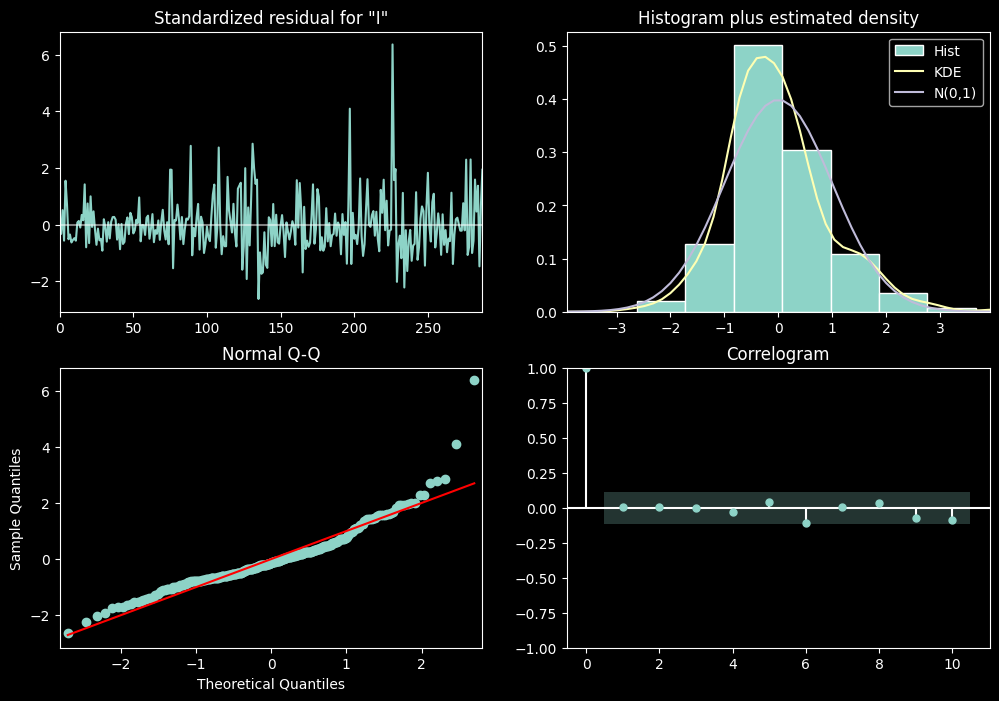

In [68]:
optimized_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [69]:
test_size = 12
train_data = df['Index value'][:-test_size]
test_data = df['Index value'][-test_size:]

# Train the SARIMA model on the training data
optimized_model = SARIMAX(train_data,
                          order=(3, 1, 1),  # Optimized non-seasonal parameters
                          seasonal_order=(3, 1, 1, 12),  # Optimized seasonal parameters
                          enforce_stationarity=False,
                          enforce_invertibility=False)

# Fit the model using the Powell method to avoid convergence warnings
optimized_fit = optimized_model.fit(method='powell', disp=False)

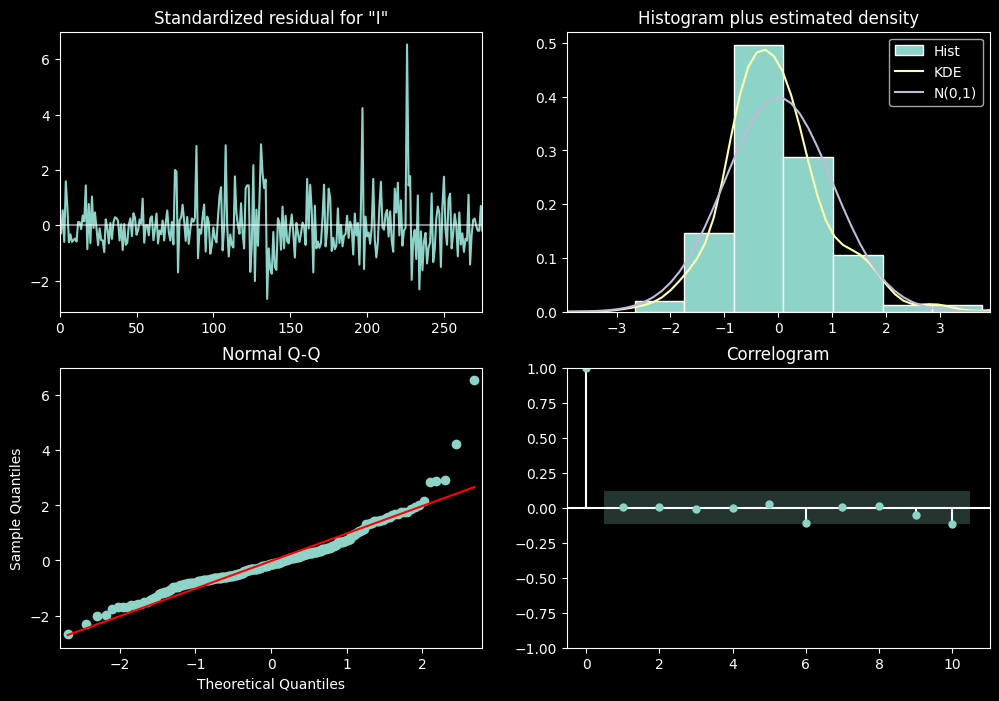

In [70]:
optimized_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [71]:
# Generate forecast for the test period
forecast = optimized_fit.get_forecast(steps=test_size)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [72]:
# Evaluate model performance
mae = mean_absolute_error(test_data, forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
mape = np.mean(np.abs((test_data - forecast_mean) / test_data)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 31.26
Root Mean Squared Error (RMSE): 37.00
Mean Absolute Percentage Error (MAPE): 17.52%


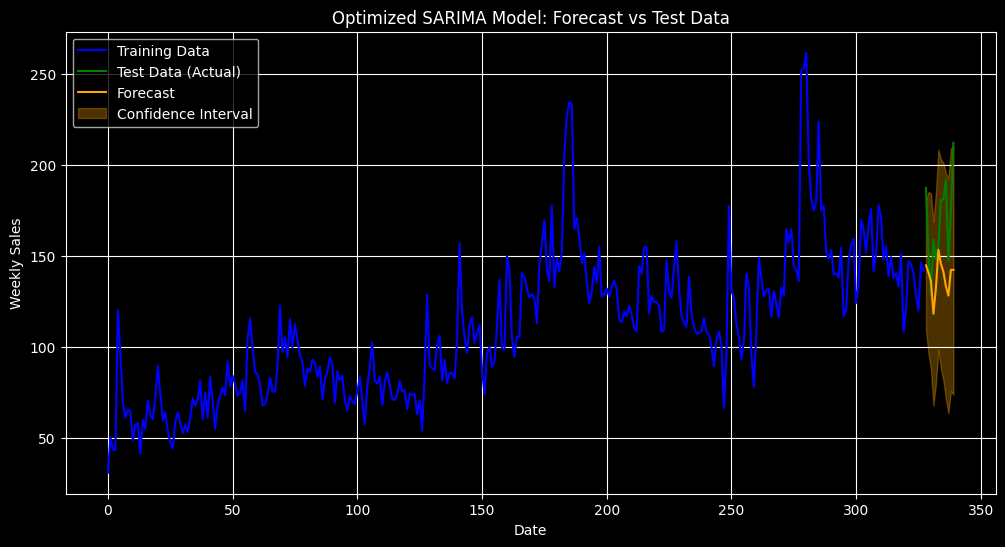

In [73]:
# Plot the forecast against the test data
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_data, label='Training Data', color='blue')

# Plot test data
plt.plot(test_data, label='Test Data (Actual)', color='green')

# Plot forecasted values
plt.plot(test_data.index, forecast_mean, label='Forecast', color='orange')

# Plot confidence intervals
plt.fill_between(test_data.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3, label='Confidence Interval')

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.title('Optimized SARIMA Model: Forecast vs Test Data')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid()
plt.show()

#### 5.4. ARCH & GARCH

In [74]:
returns = df[['Date', 'Index value']].copy()
returns['y'] = returns['Index value'].pct_change().dropna()
returns = returns.dropna()[['Date', 'y']].rename(columns={'Date': 'ds'}); returns
returns['unique_id'] = 'epu index'
returns


,ds,y,unique_id
1,1997-02-01,0.634367,epu index
2,1997-03-01,-0.136911,epu index
3,1997-04-01,-0.007462,epu index
4,1997-05-01,1.772732,epu index
5,1997-06-01,-0.207043,epu index
...,...,...,...
335,2024-12-01,0.001676,epu index
336,2025-01-01,0.060401,epu index
337,2025-02-01,-0.230619,epu index
338,2025-03-01,0.184354,epu index


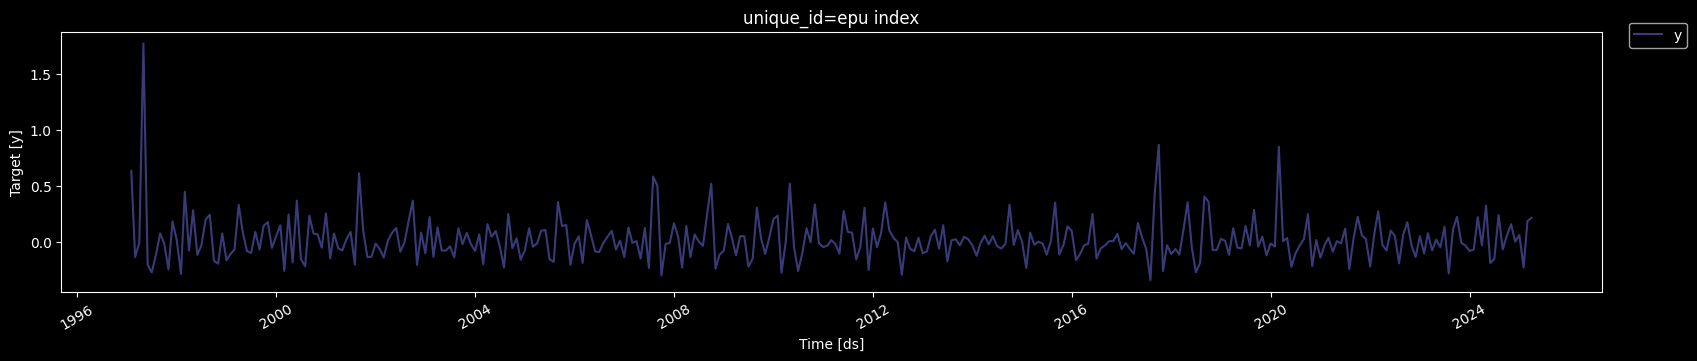

In [75]:
StatsForecast.plot(
    df=returns
)

In [76]:
y = df['Index value'].pct_change().dropna()
y = y * 100  

p_list = [1, 2, 3]      
q_list = [0, 1, 2]    
best = {'type':None, 'order':None, 'aic':np.inf}

warnings.filterwarnings("ignore")

for p in p_list:
    try:
        m = arch_model(y, mean='Constant', vol='ARCH', p=p, o=0, q=0, dist='normal')
        res = m.fit(disp='off')
        print(f"ARCH({p}) → AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'type':'ARCH', 'order':(p,), 'aic':res.aic})
    except Exception as e:
        print(f"  ARCH({p}) failed:", e)

for p, q in itertools.product(p_list, q_list):
    if q == 0: 
        continue  
    try:
        m = arch_model(y, mean='Constant', vol='GARCH', p=p, o=0, q=q, dist='normal')
        res = m.fit(disp='off')
        print(f"GARCH({p},{q}) → AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'type':'GARCH', 'order':(p,q), 'aic':res.aic})
    except Exception as e:
        print(f"  GARCH({p},{q}) failed:", e)

# 5. Kết quả
if best['type'] is not None:
    print("\n==> Best model:")
    print(f"  Type   : {best['type']}")
    print(f"  Order  : {best['order']}")
    print(f"  AIC    : {best['aic']:.2f}")
else:
    print("Cannot find best model, please check again p/q.")


ARCH(1) → AIC=2999.80
ARCH(2) → AIC=3000.79
ARCH(3) → AIC=2943.93
GARCH(1,1) → AIC=2939.89


GARCH(1,2) → AIC=2939.63
GARCH(2,1) → AIC=2941.89
GARCH(2,2) → AIC=2941.63
GARCH(3,1) → AIC=2943.89
GARCH(3,2) → AIC=2943.63

==> Best model:
  Type   : GARCH
  Order  : (1, 2)
  AIC    : 2939.63


In [77]:
models = [
    ARCH(1),
    GARCH(1,1),
    GARCH(1,2),
    Naive()
]

sf = StatsForecast(models=models, freq='MS', n_jobs=-1)

cv_df = sf.cross_validation(
    df        = returns,
    h         = 12,
    step_size = 12,
    n_windows = 4
)


In [78]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True)
cv_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),"GARCH(1,1)","GARCH(1,2)",Naive
0,epu index,2021-05-01,2021-04-01,0.004400,0.327294,0.258311,0.326634,-0.088288
1,epu index,2021-06-01,2021-04-01,-0.014939,-0.134054,-0.119999,-0.135038,-0.088288
2,epu index,2021-07-01,2021-04-01,0.116784,-0.107414,-0.098487,-0.107582,-0.088288
3,epu index,2021-08-01,2021-04-01,-0.243733,-0.216938,-0.190016,-0.216689,-0.088288
4,epu index,2021-09-01,2021-04-01,0.032200,0.180562,0.162536,0.180976,-0.088288


This returns series is also get some volatility, so we need to use ARCH/GARCH model to forecast the volatility.

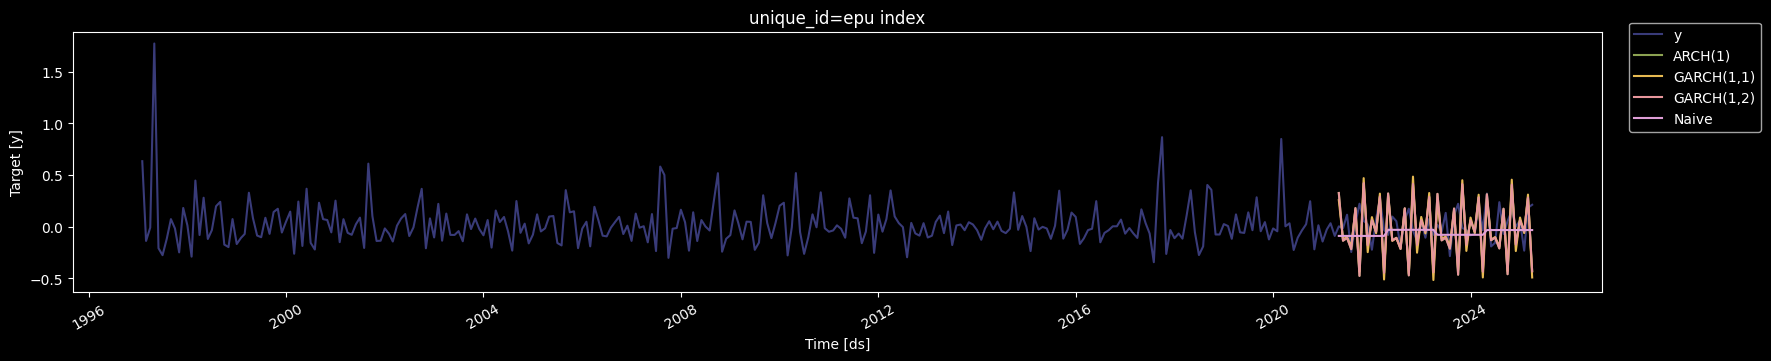

In [79]:
StatsForecast.plot(returns, cv_df.drop(['cutoff', 'actual'], axis=1))


In [80]:
model_cols = [col for col in cv_df.columns if col not in ['unique_id', 'ds', 'cutoff', 'actual']]

metrics = []
for model in model_cols:
    y_true = cv_df['actual']
    y_pred = cv_df[model]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
    metrics.append({
        'Model': model,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape
    })

metrics_df = pd.DataFrame(metrics).set_index('Model')
print(metrics_df)

                RMSE       MAE    MAPE (%)
Model                                     
ARCH(1)     0.297584  0.227908  757.878094
GARCH(1,1)  0.307695  0.241640  834.143980
GARCH(1,2)  0.298768  0.228979  764.556452
Naive       0.164604  0.136963  233.825667
